ISMI Team 5 - VerSe 2019
-----------------------------

This notebook contains the code to train and evaluate an [EfficientNet](https://arxiv.org/abs/1905.11946) based model.
Our model is defined in the VertebraeLocalizer class and can be adjusted by using several parameters.

 - `link_conf` enables the option to use the confidence as the input for the coordinate prediction
 - `num_skipconnections` defines the number of skip connections to be added
 
The notebook prepares two different dataset with a 80/10/10 train/test/val split. One is using affine transformations to augment the data.

_The current state of this notebook does not contain the output of our training_ since we have done this outside Jupyter. Our initial testing however was done using this notebook with 10 epochs instead of the 300 used during training.

The output of the 300 epoch training can be found in the figures below. These models were trained on a Google Cloud instance with a Tesla P100 GPU with a maximum epoch length of 10 seconds for the b6 networks. A trained b6 model is available [here](https://gitlab.science.ru.nl/ismi5/project/-/blob/model/efficientnet-b6-aug.zip).


| Model | Loss | Score | Id-rate | Inverted distance 
| - | - | - | - | - |
efficientnet-b1          | 2.268904 | 0.40989 |  0.359069 |  0.511532
efficientnet-b4          |  1.683857 |  0.423611 |  0.363460 |  0.543915
efficientnet-b6          |  1.394953 |  0.402621 |  0.338440 |  0.530985
efficientnet-b1-conf     |  2.357249 |  0.361013 |  0.300960 |  0.481119
efficientnet-b4-conf     |  1.734579 |  0.396169 |  0.336499 |  0.515511
efficientnet-b6-conf     |  1.309693 |  0.380221 |  0.312806 |  0.515053
efficientnet-b1-aug      |  0.768137 |  0.584075 |  0.496586 |  0.759054
efficientnet-b4-aug      |  0.926808 |  0.419602 |  0.343546 |  0.571715
efficientnet-b6-aug      |  0.786854 |  0.563053 |  0.491217 |  0.706728
efficientnet-b1-aug-conf |  0.799485 |  0.538238 |  0.499037 |  0.616640
efficientnet-b4-aug-conf |  0.885503 |  0.457083 |  0.396446 |  0.578357
efficientnet-b6-aug-conf |  0.719172 |  0.514436 |  0.445159 |  0.652992

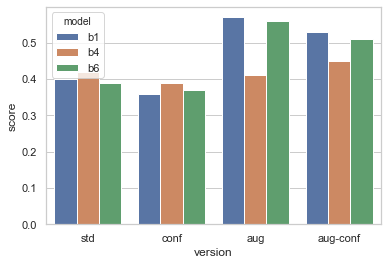


## How to use

You should have received this notebook with a `requirements.txt` and the `wfs` library. Both are required to run every piece of code in this notebook. Place the `wfs` package in the same directory as this notebook to use it and use `pip install -r requirements.txt` to install all the required parameters. Note that the minimal Python version for this notebook is supposed to be *Python 3.6*. Even though we have mostly done training using Python 3.7.

We advise you to create a virtual env using `python3 -m venv venv` and using that environment to not install all the libraries globally.

Then last you should adjust the `DATA_DIR` variable to be able to read all the images and save the information as numpy file before starting training.

To just use a trained model to do predictions we have also added the `predict.py` script.

## Preprocessing

The images used in the model are [Maximum Intensity Projections](https://en.wikipedia.org/wiki/Maximum_intensity_projection) of the XY and XZ planes of the input 3D images. We apply contrast stretching, denoising and resizing (256 x 128 x 128) to normalise the input images.

## Evaluation

The evaluation measures that are calculated are based on the measures introduced in [Sekuboyina, Anjany, et al. "VerSe: A Vertebrae Labelling and Segmentation Benchmark."](https://arxiv.org/abs/2001.09193) that were also used in the original VerSe 2019 Grand-Challenge. It is not 100% but we have tried to use similar measures.

 - Identification rate
 - Localisation distance
   - Normalised and inversed
 - Score: 2/3 x identification rate + 1/3 distance


In [ ]:
import glob
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import SimpleITK as sitk
import tensorflow as tf
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from skimage import restoration

In [2]:
np.set_printoptions(suppress=True)
sns.set('notebook', style={'axes.facecolor': 'white', 'grid': False})

In [33]:
FLAG_LOAD_NPY = True                # If True will load cached data from .npy files

LABEL_COUNT = 25                    # Number of labels in the dataset
SLICE_SHAPE = (128, 256)            # All images will be resized to create slices of this shape
BATCH_SIZE = 8                      # Batch size

# Contrast-stretching parameters
CUTOFF_LOWER = 0 
CUTOFF_UPPER = 2000

# Denoising parameters
DENOISE_METHOD = 'chambolle'
DENOISE_STRENGTH = 0.02

# Loss weight parameters [confidence, Z, Y, X]
LOSS_WEIGHT_CONFIDENCE = 1
LOSS_WEIGHT_ZYX = [1, 1, 1]

# Ignore these training images since they are of low quality
IGNORE_INDICES = [2, 15, 25, 31]

# The following training images contain very bright structures in the scan, ignore them for now 
IGNORE_INDICES += [7, 11, 19, 49]

# C1 - L6
ANNOTATIONS = [f'c{i}' for i in range(1, 8)] + [f'Th{i}' for i in range(1, 13)] + [f'L{i}' for i in range(1, 7)]

In [4]:
IMAGE_SHAPE = SLICE_SHAPE[:1] + SLICE_SHAPE

In [10]:
DATA_DIR = './data/training_data/'

PATH_JSONS = sorted(glob.glob(DATA_DIR + '*.json'))
PATH_IMAGES = sorted(glob.glob(DATA_DIR + 'verse[0-9][0-9][0-9].nii.gz'))

NUM_IMAGES = len(PATH_IMAGES)

## Read data

In [11]:
def contrast_stretching(image, p0, pk, q0=None, qk=None):
    if q0 is None:
        q0 = p0
        
    if qk is None:
        qk = pk
    
    return np.clip(q0 + (qk - q0) * (image - p0) / (pk - p0), q0, qk)

def denoise(image, method, strength):
    if method == 'chambolle':
        return restoration.denoise_tv_chambolle(image, strength)
        
    if method == 'bregman':
        return restoration.denoise_tv_bregman(image, 1 / strength)
    
    raise NotImplementedError('Denoise method `%s` is not implemented.')

In [12]:
def load_normalized_image_labels(index):
    # Load image
    file_image = sitk.ReadImage(PATH_IMAGES[index])

    # Build inverse affine from file
    affine = np.linalg.inv(np.array(file_image.GetDirection()).reshape(3, 3))

    # Extract axes swaps
    swaps = np.argmax(np.abs(affine), axis=0).astype(np.int)

    # Extract axes flips and correct them
    flips = np.sum(affine.round(), axis=0).astype(np.int)
    flips[2] *= -1

    # Extract spacings from file and correct them
    spacings = np.array(file_image.GetSpacing())[swaps]

    # Read image data from file
    image = sitk.GetArrayViewFromImage(file_image).astype(np.float32)
    
    # Swap axes to standard orientation (zyx)
    image = np.transpose(np.transpose(image, (2, 1, 0)), swaps)

    # Flip axes to standard directions
    image = image[tuple(slice(None, None, int(f)) for f in flips)]
    
    # Calculate scaling ratios
    scale_ratios_image = np.divide(IMAGE_SHAPE, image.shape)
    scale_ratios_labels = np.reciprocal(spacings * image.shape)

    # Resize image
    image = zoom(image, scale_ratios_image)
    
    # Constrast stretching
    image = contrast_stretching(image, CUTOFF_LOWER, CUTOFF_UPPER, 0, 1)

    # Denoising
    image = denoise(image, DENOISE_METHOD, DENOISE_STRENGTH)

    # Maximum intensity projections
    image_xy = image.max(axis=0).astype(np.float32)
    image_xz = image.max(axis=1).astype(np.float32)

    # Build slices
    slices = np.stack([image_xy, image_xz], axis=-1).astype(np.float32)
    
    # Build onehot labels as [present, z, y, x]
    with open(PATH_JSONS[index]) as f:
        labels = json.load(f)
    
    labels_onehot = np.zeros((LABEL_COUNT, 4), dtype=np.float32)
    for label in labels:
        labels_onehot[label['label'] - 1] = [1, label['Z'], label['Y'], label['X']]

    # Normalize labels of image_size
    labels_onehot[:, 1:] *= scale_ratios_labels

    return slices, labels_onehot

In [13]:
if FLAG_LOAD_NPY:
    x_all = np.load(DATA_DIR + 'x_all.npy').astype(np.float32)
    y_all = np.load(DATA_DIR + 'y_all.npy').astype(np.float32)

else:
    n = len(PATH_IMAGES)

    x_all = np.zeros((n,) + SLICE_SHAPE + (2,), dtype=np.float32)
    y_all = np.zeros((n, LABEL_COUNT, 4), dtype=np.float32)

    for i in tqdm(range(len(PATH_IMAGES)), unit='img', desc='Loading data'):
        x_all[i], y_all[i] = load_normalized_image_labels(i)

    np.save(DATA_DIR + 'x_all.npy', x_all)
    np.save(DATA_DIR + 'y_all.npy', y_all)

In [14]:
indices = np.arange(x_all.shape[0])
train_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=2020)
train_indices, val_indices = train_test_split(train_indices, test_size=1/9, random_state=2020)
# train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=2020)
# train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=2020)

train_indices = [i for i in train_indices if i not in IGNORE_INDICES]

x_train, y_train = x_all[train_indices], y_all[train_indices]
x_val, y_val = x_all[val_indices], y_all[val_indices]
x_test, y_test = x_all[test_indices], y_all[test_indices]

print(len(x_train), 'training images')
print(len(x_val), 'validation images')
print(len(x_test), 'test images')

52 training images
8 validation images
8 test images


## Visualization

In [15]:
# Style parameters
kwargs_image = dict(cmap=sns.cm.rocket, aspect='equal')
kwargs_label_true = dict(c='white', marker='x', s=12)
kwargs_label_pred = dict(c='springgreen', marker='x', s=12)
kwargs_annotation_true = dict(c='yellow', fontsize=12, fontweight='bold')
kwargs_annotation_pred = dict(c='green', fontsize=12, fontweight='bold')

In [16]:
def plot_image_labels(slices, labels_true=None, labels_pred=None, label_confidence_threshold=0.5):
    plot_true = labels_true is not None
    plot_pred = labels_pred is not None

    annot_true, annot_pred = [], []
    
    # Select existing labels
    if plot_true:
        label_xyz_true = []
        for i, label in enumerate(labels_true):
            if label[0] == 1:
                label_xyz_true.append(label[1:])
                annot_true.append(ANNOTATIONS[i])
        label_xyz_true = np.array(label_xyz_true)

        # Rescale back to image size
        label_xyz_true *= IMAGE_SHAPE
    
    # Select labels with confidence above the threshold
    if plot_pred:
        label_xyz_pred = []
        for i, label in enumerate(labels_pred):
            if label[0] > label_confidence_threshold:
                label_xyz_pred.append(label[1:])
                annot_pred.append(ANNOTATIONS[i])
        label_xyz_pred = np.array(label_xyz_pred)
        
        # Rescale back to image size
        label_xyz_pred *= IMAGE_SHAPE
    
    fig, axes = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(10, 5), gridspec_kw=dict(wspace=0))
    
    # Plot X-Y slice of data
    axes[0].imshow(slices[:, :, 0], **kwargs_image)
    if plot_true:
        for (x, y, txt) in zip(label_xyz_true[:, 2], label_xyz_true[:, 1], annot_true):
            axes[0].scatter(x, y, **kwargs_label_true)
            axes[0].text(x, y - 10, txt, **kwargs_annotation_true)

    if plot_pred:
        for (x, y, txt) in zip(label_xyz_pred[:, 2], label_xyz_pred[:, 1], annot_pred):
            axes[0].scatter(x, y, **kwargs_label_pred)
            axes[0].text(x, y - 10, txt, **kwargs_annotation_pred)
    axes[0].axis('off')

    # Plot X-Z slice of data
    axes[1].imshow(slices[:, :, 1], **kwargs_image)
    if plot_true:
        for (x, z, txt) in zip(label_xyz_true[:, 2], label_xyz_true[:, 0], annot_true):
            axes[1].scatter(x, z, **kwargs_label_true)
            axes[1].text(x, z - 10, txt, **kwargs_annotation_true)
    if plot_pred:
        for (x, z, txt) in zip(label_xyz_pred[:, 2], label_xyz_pred[:, 0], annot_pred):
            axes[1].scatter(x, z, **kwargs_label_pred)
            axes[1].text(x, z - 10, txt, **kwargs_annotation_pred)
    axes[1].axis('off')

## Model

In [ ]:
import wfs
import wfs.augmentation as A
wfs.tfstrategy = tf.distribute.get_strategy()

In [18]:
import wfs.augmentation.image.affine as affine

# Use small values for max_angle since the affine implementation does not handle angles very accurately
class VertebraeAffineAugmentation(A.Augmentation):
    def __init__(self, max_shift_ratio, max_angle, zoom, zoom_upper=None, keep_aspect=True, border_mode='zero', fill=None, p=1):
        super().__init__(1, 'xy')
        
        self.max_shift_ratio = tf.cast(max_shift_ratio, tf.float32)
        self.max_angle = tf.cast(max_angle, tf.float32)
        if zoom_upper is None:
            zoom_lower = 1 - zoom
            zoom_upper = 1 + zoom
        else:
            zoom_lower = zoom
        self.zoom_lower = tf.cast(zoom_lower, tf.float32)
        self.zoom_upper = tf.cast(zoom_upper, tf.float32)

        self.keep_aspect = keep_aspect
        self.border_func, self.fill = affine.border_mode_string_to_func(border_mode, fill)
        
    def apply_xy(self, x_batch, y_batch):
        shape = tf.shape(x_batch)
        batch_size = shape[0]
        yz_image_size = tf.cast(shape[1], dtype=tf.float32)
        x_image_size = tf.cast(shape[2], dtype=tf.float32)
        image_shape = tf.stack([yz_image_size, x_image_size])

        # Generate shift ratios
        x_shift_ratios = tf.random.uniform((batch_size,), -self.max_shift_ratio, self.max_shift_ratio, dtype=tf.float32)
        y_shift_ratios = tf.random.uniform((batch_size,), -self.max_shift_ratio, self.max_shift_ratio, dtype=tf.float32)
        z_shift_ratios = tf.random.uniform((batch_size,), -self.max_shift_ratio, self.max_shift_ratio, dtype=tf.float32)
        shift_ratios_stack = tf.expand_dims(tf.stack([tf.zeros((batch_size,), dtype=tf.float32), z_shift_ratios, y_shift_ratios, x_shift_ratios], axis=1), axis=1)
        shift_mid_stack = tf.convert_to_tensor([0, 0.5, 0.5, 0.5], dtype=tf.float32)
        
        # Calculate shifts
        x_shifts = x_shift_ratios * x_image_size
        y_shifts = y_shift_ratios * yz_image_size
        z_shifts = z_shift_ratios * yz_image_size

        # Generate rotation angles
        xy_angles = tf.random.uniform((batch_size,), -self.max_angle, self.max_angle, dtype=tf.float32)

        xy_angles *= np.pi / 180
        xy_angles_cos = tf.math.cos(xy_angles)
        xy_angles_sin = tf.math.sin(xy_angles)
        xy_rot_matrix = tf.reshape(tf.stack([xy_angles_cos, -xy_angles_sin, xy_angles_sin, xy_angles_cos], axis=1), (-1, 2, 2))
        
        xz_angles = tf.random.uniform((batch_size,), -self.max_angle, self.max_angle, dtype=tf.float32)
        xz_angles *= np.pi / 180
        xz_angles_cos = tf.math.cos(xz_angles)
        xz_angles_sin = tf.math.sin(xz_angles)
        xz_rot_matrix = tf.reshape(tf.stack([xz_angles_cos, -xz_angles_sin, xz_angles_sin, xz_angles_cos], axis=1), (-1, 2, 2))
        
        # Split slices
        xy_slices, xz_slices = x_batch[:, :, :, :1], x_batch[:, :, :, 1:]
        
        if self.keep_aspect:
            # Generate zooms
            zooms = tf.random.uniform((batch_size,), self.zoom_lower, self.zoom_upper, dtype=tf.float32)
            zooms_stacked = tf.expand_dims(tf.stack([tf.ones((batch_size,), dtype=tf.float32), zooms, zooms, zooms], axis=1), axis=1)
            
            # Correct zooms for rotations of other slice
            xy_x_zooms = zooms * xz_angles_cos
            xz_x_zooms = zooms * xy_angles_cos
            
            # Apply transformations to x_batch
            xy_slices = affine.shift_rotate_shear_zoom(xy_slices, x_shifts=x_shifts, y_shifts=y_shifts, angles=xy_angles, x_zooms=xy_x_zooms, y_zooms=zooms, border_func=self.border_func, fill=self.fill)
            xz_slices = affine.shift_rotate_shear_zoom(xz_slices, x_shifts=x_shifts, y_shifts=z_shifts, angles=xz_angles, x_zooms=xz_x_zooms, y_zooms=zooms, border_func=self.border_func, fill=self.fill)
            x_batch = tf.concat([xy_slices, xz_slices], axis=3)
            
        else:
            # Generate zooms
            x_zooms = tf.random.uniform((batch_size,), self.zoom_lower, self.zoom_upper, dtype=tf.float32)
            y_zooms = tf.random.uniform((batch_size,), self.zoom_lower, self.zoom_upper, dtype=tf.float32)
            z_zooms = tf.random.uniform((batch_size,), self.zoom_lower, self.zoom_upper, dtype=tf.float32)
            zooms_stacked = tf.expand_dims(tf.stack([tf.ones((batch_size,), dtype=tf.float32), z_zooms, y_zooms, x_zooms], axis=1), axis=1)

            # Correct zooms for rotations of other slice
            xy_x_zooms = x_zooms * xz_angles_cos
            xz_x_zooms = x_zooms * xy_angles_cos
            
            # Apply transformations to x_batch
            xy_slices = affine.shift_rotate_shear_zoom(xy_slices, x_shifts=x_shifts, y_shifts=y_shifts, angles=xy_angles, x_zooms=xy_x_zooms, y_zooms=y_zooms, border_func=self.border_func, fill=self.fill)
            xz_slices = affine.shift_rotate_shear_zoom(xz_slices, x_shifts=x_shifts, y_shifts=z_shifts, angles=xz_angles, x_zooms=xz_x_zooms, y_zooms=z_zooms, border_func=self.border_func, fill=self.fill)
            x_batch = tf.concat([xy_slices, xz_slices], axis=3)
            
        # Apply transformations to y_batch
        # Perform shifts and set origin to the center of image
        y_batch += shift_ratios_stack - shift_mid_stack

        # Perform zooms
        y_batch *= zooms_stacked

        # Perform x-y rotations
        y_batch_c, y_batch_z, y_batch_yx = y_batch[:, :, :1], y_batch[:, :, 1:2], y_batch[:, :, 2:]
        y_batch_yx *= image_shape
        y_batch_yx = tf.einsum('bij,bkj->bki', xy_rot_matrix, y_batch_yx)
        y_batch_yx /= image_shape
        y_batch_y, y_batch_x = y_batch_yx[:, :, :1], y_batch_yx[:, :, 1:]

        # Perform x-z rotations
        y_batch_zx = tf.concat([y_batch_z, y_batch_x], axis=2)
        y_batch_zx *= image_shape
        y_batch_zx = tf.einsum('bij,bkj->bki', xz_rot_matrix, y_batch_zx)
        y_batch_zx /= image_shape
        y_batch_z, y_batch_x = y_batch_zx[:, :, :1], y_batch_zx[:, :, 1:]
        y_batch = tf.concat([y_batch_c, y_batch_z, y_batch_y, y_batch_x], axis=2)

        # Set origin back
        y_batch += shift_mid_stack
        
        return x_batch, y_batch

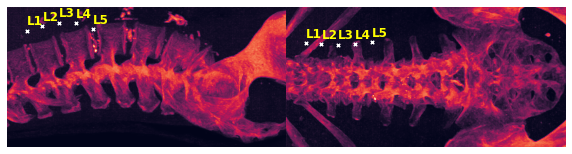

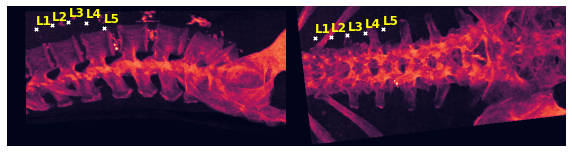

In [19]:
image, labels = x_all[1:4], y_all[1:4]

index = 0

plot_image_labels(np.squeeze(image[index]), np.squeeze(labels[index]))

aug = VertebraeAffineAugmentation(0.2, 20, 0.2, keep_aspect=False, border_mode='fill', fill=[0])

image, labels = aug(image, labels)

plot_image_labels(np.squeeze(image[index]), np.squeeze(labels[index]))

In [20]:
class VertebraeLocalizationLoss(tf.keras.losses.Loss):
    def __init__(self, reduced=True):
        self.reduced = reduced
        if not reduced:
            super().__init__(reduction=tf.keras.losses.Reduction.NONE)
        else:
            super().__init__(reduction=tf.keras.losses.Reduction.AUTO)
        
        with wfs.tfstrategy.scope():
            self.loss_conf = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)


    def call(self, y_true, y_pred):      
        with wfs.tfstrategy.scope():  
            y_true = tf.transpose(y_true, [0, 2, 1])
            y_pred = tf.transpose(y_pred, [0, 2, 1])

            presents = y_true[:, :1]
            loss_zyx = tf.transpose(presents * tf.math.square(y_true[:, 1:] - y_pred[:, 1:]), [0, 2, 1])
            loss_zyx = tf.math.reduce_sum(LOSS_WEIGHT_ZYX * loss_zyx)
            loss_confidence = LOSS_WEIGHT_CONFIDENCE * self.loss_conf(y_true[:, 0], y_pred[:, 0])

            if self.reduced:
                return loss_zyx + loss_confidence

            return loss_zyx, loss_confidence

In [21]:
CONFIDENCE_THRESHOLD = 0.5
DISTANCE_THRESHOLD = 20
MAX_DISTANCE = 50 * DISTANCE_THRESHOLD

# DEPRECATED, superseded by average_identification_rate
def confidence_accuracy(y_true, y_pred):
    return tf.math.reduce_mean(tf.keras.metrics.binary_accuracy(y_true[:, :, 0], y_pred[:, :, 0]))

def get_distances(true_position, predicted_vertebrae):
    # Compute pixel locations from float values
    true_zyx = true_position * IMAGE_SHAPE
    predicted_zyx = predicted_vertebrae[:, 1:] * IMAGE_SHAPE

    # Compute the Euclidean distance between the actual position and each predicted position
    distances = tf.sqrt(tf.math.reduce_sum(tf.math.square(predicted_zyx - true_zyx), axis=1))

    # For each vertebra that is not predicted, or is too far away, don't count it
    # (i.e. set it to the max distance, like in the paper)
    actual_vertebrae = tf.math.logical_and(predicted_vertebrae[:, 0] > CONFIDENCE_THRESHOLD,
                                           distances < DISTANCE_THRESHOLD)

    return tf.where(actual_vertebrae, distances, MAX_DISTANCE)

def localisation_distance(y_true, y_pred):
    # Compute the pairwise distance between all true and predicted vertebrae, and keep only the diagonal
    # Vertebrae that don't exist in our prediction have a distance of MAX_DISTANCE
    distances = tf.linalg.diag_part(tf.map_fn(lambda row: get_distances(row[1:], y_pred), y_true, dtype=tf.float32))

    # Vertebrae that don't exist in the true labels should not be included in the metric
    present_vertebrae = tf.where(y_true[:, 0] == 1)
    true_distances = tf.gather_nd(distances, present_vertebrae)

    return tf.math.reduce_mean(true_distances)

def average_localisation_distance(y_true, y_pred):
    # Compute the mean localisation distance across a batch
    distances = tf.map_fn(lambda t: localisation_distance(*t), (y_true, y_pred), dtype=tf.float32)

    return tf.math.reduce_mean(distances)

def inversed_normalized_average_localisation_distance(y_true, y_pred):
    return 1 - average_localisation_distance(y_true, y_pred) / MAX_DISTANCE

def identification_rate(y_true, y_pred):
    # For each true vertebra, compute the index of the closest predicted vertebra
    closest = tf.map_fn(lambda row: tf.math.argmin(get_distances(row[1:], y_pred), output_type=tf.int32), y_true, dtype=tf.int32)

    # Discard vertebrae that are not in the image
    present_vertebrae = tf.where(y_true[:, 0] == 1)
    predictions = tf.gather_nd(closest, present_vertebrae)
    true_labels = tf.gather_nd(tf.range(y_true.shape[0]), present_vertebrae)

    # Compute ratio of correctly predicted labels
    accuracy = tf.keras.metrics.Accuracy()

    return accuracy(true_labels, predictions)

def average_identification_rate(y_true, y_pred):
    # Compute the mean identification rate across a batch
    rates = tf.map_fn(lambda t: identification_rate(*t), (y_true, y_pred), dtype=tf.float32)

    return tf.math.reduce_mean(rates)

def verse_metric(y_true, y_pred):
    # Weighted average of the identification_rate and localisation distance
    return (2 * average_identification_rate(y_true, y_pred) + inversed_normalized_average_localisation_distance(y_true, y_pred)) / 3

In [ ]:
class VertebraeLocalizer(wfs.trainer.BackboneTrainer):
    def __init__(self, *args, link_conf=False, num_skipconnections=0, **kwargs):
        self.link_conf = link_conf
        self.num_skipconnections = num_skipconnections
        super().__init__(*args, **kwargs)
    
    def _init_model(self, weights, dropout_rate, **kwargs):
        with wfs.tfstrategy.scope():
            inputs = tf.keras.layers.Input(shape=self.data.x_shape)
            
            slices_xy = tf.keras.layers.Lambda(lambda x: x[:, :, :, 0], name='xy_slicer')(inputs)
            base_xy = self.backbone.build_model(input_tensor=slices_xy, weights=weights, **kwargs)
            
            slices_xz = tf.keras.layers.Lambda(lambda x: x[:, :, :, 1], name='xz_slicer')(inputs)
            base_xz = self.backbone.build_model(input_tensor=slices_xz, weights=weights, **kwargs)
            
            xy_skiplayers, xz_skiplayers = [], []
            for i, layer in enumerate(base_xy.layers):
                if(self.num_skipconnections > 0 and 'Dropout' in layer.__class__.__name__):
                    xy_skiplayers.append(base_xy.layers[i - 1])
                layer._name = 'xy_' + layer.name
                
            for i, layer in enumerate(base_xz.layers):
                if(self.num_skipconnections > 0 and 'Dropout' in layer.__class__.__name__):
                    xz_skiplayers.append(base_xz.layers[i - 1])
                layer._name = 'xz_' + layer.name
            
            out_xy = tf.keras.layers.Flatten(name='xy_top_flatten')(base_xy.output)
            out_xz = tf.keras.layers.Flatten(name='xz_top_flatten')(base_xz.output)
            
            if self.num_skipconnections > 0:
                skip_layer = tf.keras.layers.Flatten(name='skip_layer')
                out_xy = tf.keras.layers.concatenate([out_xy] + [skip_layer(layer.output) for layer in xy_skiplayers[:self.num_skipconnections]])       
                out_xz = tf.keras.layers.concatenate([out_xz] + [skip_layer(layer.output) for layer in xz_skiplayers[:self.num_skipconnections]])

            if dropout_rate == 'default':
                dropout_rate = self.backbone.default_dropout_rate
                
            if dropout_rate is not None:
                out_xy = tf.keras.layers.Dropout(dropout_rate, name='xy_top_dropout')(out_xy)
                out_xz = tf.keras.layers.Dropout(dropout_rate, name='xz_top_dropout')(out_xz)

            concat = tf.concat([out_xy, out_xz], axis=-1)
    
            if self.link_conf:
                predicts_conf = tf.keras.layers.Dense(LABEL_COUNT, activation='sigmoid', name='output_conf')(concat)
                concat_x = tf.concat([concat, predicts_conf], axis=-1)
                predicts_x = tf.keras.layers.Dense(LABEL_COUNT, activation='sigmoid', name='output_x')(concat_x)
                concat_y = tf.concat([out_xy, predicts_conf ], axis=-1)
                predicts_y = tf.keras.layers.Dense(LABEL_COUNT, activation='sigmoid', name='output_y')(concat_y)
                concat_z = tf.concat([out_xz, predicts_conf], axis=-1)
                predicts_z = tf.keras.layers.Dense(LABEL_COUNT, activation='sigmoid', name='output_z')(concat_z)
            else:
                predicts_conf = tf.keras.layers.Dense(LABEL_COUNT, activation='sigmoid', name='output_conf')(concat)
                predicts_x = tf.keras.layers.Dense(LABEL_COUNT, activation='sigmoid', name='output_x')(concat)
                predicts_y = tf.keras.layers.Dense(LABEL_COUNT, activation='sigmoid', name='output_y')(out_xy)
                predicts_z = tf.keras.layers.Dense(LABEL_COUNT, activation='sigmoid', name='output_z')(out_xz)

            out = tf.stack([predicts_conf, predicts_z, predicts_y, predicts_x], axis=-1)

            self.model = tf.keras.Model(inputs=inputs, outputs=out)

In [26]:
data_train = wfs.data.TFData.from_numpy(
    x_train, y_train,
    preprocess_input=A.Sequence(
        A.ToTripleChannel(),
        A.NormalizeImagenet(),
    ),
    data_type=wfs.data_type.TRAIN,
    batch_size=BATCH_SIZE,
)

data_train_aug = wfs.data.TFData.from_numpy(
    x_train, y_train,
    preprocess_input=A.NormalizeImagenet(),
    data_type=wfs.data_type.TRAIN,
    batch_size=BATCH_SIZE,
    augmentation=A.Sequence(
        VertebraeAffineAugmentation(0.2, 20, 0.2, keep_aspect=False, border_mode='fill', fill=[0]),
        A.ToTripleChannel(),
        A.RGB_FLOAT_to_HSV(),
        A.HSV_Saturation_Value(0.05),
        A.HSV_to_RGB_FLOAT(),
    ),
)

data_val = wfs.data.TFData.from_numpy(
    x_val, y_val,
    preprocess_input=A.Sequence(
        A.ToTripleChannel(),
        A.NormalizeImagenet(),
    ),
    data_type=wfs.data_type.VAL,
    batch_size=BATCH_SIZE,
)

data_test = wfs.data.TFData.from_numpy(
    x_test, y_test,
    preprocess_input=A.Sequence(
        A.ToTripleChannel(),
        A.NormalizeImagenet(),
    ),
    data_type=wfs.data_type.TEST,
    batch_size=BATCH_SIZE,
)

In [28]:
data_normal = wfs.data.Container(train=data_train, val=data_val, test=data_test)
data_aug = wfs.data.Container(train=data_train_aug, val=data_val, test=data_test)

In [ ]:
def create_model(data, backbone, link_conf=False, early_stopping=True, num_skipconnections=0):
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='score', patience=10, restore_best_weights=True)
    callbacks = [early_stopping_callback] if early_stopping else []
    return VertebraeLocalizer(
        data,
        backbone=backbone,
        weights='noisy-student',
        loss=VertebraeLocalizationLoss(),
        validation_metric=wfs.metric.Metric(verse_metric, label='score'),
        additional_metrics = [
            wfs.metric.Metric(average_identification_rate, label='id_rate'),
            wfs.metric.Metric(inversed_normalized_average_localisation_distance, label='distance'),
        ],
        additional_callbacks=callbacks,
        learning_rate=1e-5,
        link_conf=link_conf,
        num_skipconnections=num_skipconnections,
    )

models = {
    f'efficientnet-{backbone}': create_model(data_normal, f'efficientnet-{backbone}')
    for backbone in ['b1', 'b4', 'b6']
}
models.update({
    f'efficientnet-{backbone}-skipconf': create_model(data_normal, f'efficientnet-{backbone}', link_conf=True)
    for backbone in ['b1', 'b4', 'b6']
})

models.update({
    f'efficientnet-{backbone}-aug': create_model(data_aug, f'efficientnet-{backbone}')
    for backbone in ['b1', 'b4', 'b6']
})

NUM_SKIPCONNECTIONS = 2
models.update({
    f'efficientnet-{backbone}-aug-skipconn': create_model(data_aug, f'efficientnet-{backbone}', num_skipconnections=NUM_SKIPCONNECTIONS)
    for backbone in ['b1', 'b4', 'b6']
})

models.update({
    f'efficientnet-{backbone}-aug-skipconf': create_model(data_aug, f'efficientnet-{backbone}', link_conf=True)
    for backbone in ['b1', 'b4', 'b6']
})

In [ ]:
from datetime import datetime

EPOCHS = 5
save_models = False

results = []

for model_name, trainer in models.items():
    trainer.train(EPOCHS)

    loss, (score, id_rate, distance) = trainer.validate()

    results.append({
        'model': model_name,
        'loss': loss.numpy(),
        'score': score.numpy(),
        'id_rate': id_rate.numpy(),
        'distance': distance.numpy(),
    })
    
    if save_models:
        trainer.model.save(f'saved_models/{datetime.now().strftime("%Y-%m-%d")}/{EPOCHS}/{best_model}')

results = pd.DataFrame(results).set_index('model')

In [22]:
results.to_csv('results.csv')

print(results)

                                   loss     score   id_rate  distance
model                                                                
efficientnet-b1               11.902707  0.051178  0.066381  0.043576
efficientnet-b4                9.616274  0.009838  0.029514  0.000000
efficientnet-b6               10.039919  0.026942  0.045635  0.017595
efficientnet-b1-skipconf      11.801132  0.039384  0.049020  0.034567
efficientnet-b4-skipconf       9.164513  0.077287  0.092831  0.069516
efficientnet-b6-skipconf       9.798531  0.059796  0.034722  0.072332
efficientnet-b1-aug           14.921099  0.045846  0.061260  0.038139
efficientnet-b4-aug           12.200994  0.038573  0.058517  0.028601
efficientnet-b6-aug           10.966209  0.096555  0.097631  0.096017
efficientnet-b1-aug-skipconf  13.486430  0.005208  0.015625  0.000000
efficientnet-b4-aug-skipconf  10.152999  0.044573  0.049428  0.042146
efficientnet-b6-aug-skipconf  10.841679  0.010029  0.015625  0.007231


In [23]:
best_model = 'efficientnet-b6-aug'

trainer = models[best_model]

trainer.model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
xz_xy_input_9 (InputLayer)      [(None, 128, 256, 2, 0                                            
__________________________________________________________________________________________________
xy_xy_slicer (Lambda)           (None, 128, 256, 3)  0           xz_xy_input_9[0][0]              
__________________________________________________________________________________________________
xz_xz_slicer (Lambda)           (None, 128, 256, 3)  0           xz_xy_input_9[0][0]              
__________________________________________________________________________________________________
xy_stem_conv (Conv2D)           (None, 64, 128, 56)  1512        xy_xy_slicer[0][0]               
____________________________________________________________________________________________

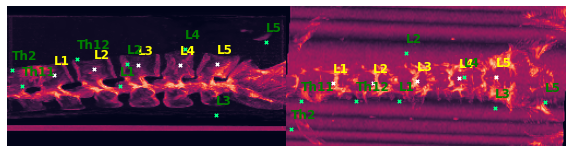

In [24]:
index = 8

image, y_true = x_all[index:index+1], y_all[index:index+1]

pre = A.Sequence(
    A.ToTripleChannel(),
    A.NormalizeImagenet(),
)

x_in, _ = pre(image, None)
y_pred = trainer.model.predict(x_in)

plot_image_labels(np.squeeze(image), np.squeeze(y_true), np.squeeze(y_pred))
plt.show()

In [25]:
loss, (score, id_rate, distance) = trainer.evaluate_test()

print('Test loss:    ', loss.numpy())
print('Test score:   ', score.numpy())
print('Test id rate: ', id_rate.numpy())
print('Test distance:', distance.numpy())

Test loss:     10.053114
Test score:    0.0447185
Test id rate:  0.04097222
Test distance: 0.04659164
